# **Trabalho Final - Processamento Digital de Imagens**

*EfficientEnsemble: Diagnostico de câncer de mama em imagens de ultrassom utilizando processamento de imagens e Ensemble de EfficientNets*

## 1) Verificação do Ambiente e Versões

In [ ]:
import tensorflow as tf, sys, numpy as np, os, platform
print("TF:", tf.__version__)
print("Python:", sys.version)
print("OS:", platform.platform())

TF: 2.19.0
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
OS: Linux-6.6.105+-x86_64-with-glibc2.35


## 2) Extrair pasta .zip

In [ ]:
!unzip -q "/content/archive.zip" -d /content/

## 3) Dependências para o filtro guiado

In [ ]:
!pip -q install opencv-contrib-python-headless==4.10.0.84

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 MB 12.1 MB/s eta 0:00:00


## 4) Imports, Configurações Gerais e Reprodutibilidade


In [ ]:
import os, sys, random, math, pathlib, json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

# Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ajustes gerais
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE_B0 = (224, 224)   # B0
IMG_SIZE_B1 = (224, 224)   # B1
IMG_SIZE_B2 = (224, 224)   # B2
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-3

BASE_DIR = "/content/Dataset_BUSI_with_GT"
assert os.path.isdir(BASE_DIR), f"Diretório não encontrado: {BASE_DIR}. Verifique o upload/descompactação."

## 5) Coleta das Imagens por Classe e Construção do DataFrame Unificado (excluindo máscaras)

In [ ]:
def list_images_no_masks(class_dir, label):
    paths = []
    for root, _, files in os.walk(class_dir):
        for f in files:
            lf = f.lower()
            if lf.endswith((".png", ".jpg", ".jpeg")) and ("mask" not in lf):
                paths.append(os.path.join(root, f))
    labels = [label] * len(paths)
    return paths, labels

benign_dir    = os.path.join(BASE_DIR, "benign")
malignant_dir = os.path.join(BASE_DIR, "malignant")
assert os.path.isdir(benign_dir) and os.path.isdir(malignant_dir), "Pastas 'benign' e/ou 'malignant' não encontradas."

benign_paths, benign_labels       = list_images_no_masks(benign_dir, 0)  # 0 = benigno
malignant_paths, malignant_labels = list_images_no_masks(malignant_dir, 1)  # 1 = maligno

all_paths  = benign_paths + malignant_paths
all_labels = benign_labels + malignant_labels

df = pd.DataFrame({"path": all_paths, "label": all_labels})
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Totais:")
print(df["label"].value_counts().rename({0:"benign",1:"malignant"}))
df.head(10)

Totais:
label
benign       437
malignant    210
Name: count, dtype: int64


,path,label
0,/content/Dataset_BUSI_with_GT/malignant/malign...,1
1,/content/Dataset_BUSI_with_GT/benign/benign (2...,0
2,/content/Dataset_BUSI_with_GT/benign/benign (2...,0
3,/content/Dataset_BUSI_with_GT/benign/benign (7...,0
4,/content/Dataset_BUSI_with_GT/benign/benign (3...,0
5,/content/Dataset_BUSI_with_GT/malignant/malign...,1
6,/content/Dataset_BUSI_with_GT/benign/benign (1...,0
7,/content/Dataset_BUSI_with_GT/benign/benign (1...,0
8,/content/Dataset_BUSI_with_GT/benign/benign (1...,0
9,/content/Dataset_BUSI_with_GT/benign/benign (1...,0


## 6) Divisão Estratificada do Dataset em Treino, Validação e Teste (60/20/20)


In [ ]:
# Dividir Dataset
train_df, temp_df = train_test_split(
    df, test_size=0.4, stratify=df["label"], random_state=SEED
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED
)

def describe_split(name, dframe):
    counts = dframe["label"].value_counts().rename({0:"benign",1:"malignant"})
    print(f"{name}: {len(dframe)} amostras |", dict(counts))

describe_split("Treino", train_df)
describe_split("Val", val_df)
describe_split("Teste", test_df)

Treino: 388 amostras | {'benign': np.int64(262), 'malignant': np.int64(126)}
Val: 129 amostras | {'benign': np.int64(87), 'malignant': np.int64(42)}
Teste: 130 amostras | {'benign': np.int64(88), 'malignant': np.int64(42)}


## 7) Extração da ROI a partir das máscaras (sem pré-processamento)



In [ ]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

ROI_DIR = "/content/ROI_BUSI"
os.makedirs(ROI_DIR, exist_ok=True)

def bbox_from_mask(mask: np.ndarray):
    """Retorna bounding box da maior componente conexa."""
    m = (mask > 0).astype(np.uint8)
    num, _, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    if num <= 1:
        ys, xs = np.where(m)
        if ys.size == 0:
            return (0, 0, mask.shape[1], mask.shape[0])
        x0, y0, x1, y1 = xs.min(), ys.min(), xs.max(), ys.max()
        return (x0, y0, x1 - x0 + 1, y1 - y0 + 1)
    idx = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    x, y, w, h, _ = stats[idx]
    return (x, y, w, h)


def extract_roi_multiple_masks(img_path: str, out_root: str):
    """
    Extrai uma ROI para cada máscara associada à imagem.
    Salva as ROIs puras (sem resize, sem filtros).
    """
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"[WARNING] imagem não encontrada: {img_path}")
        return []

    p = Path(img_path)
    cls = p.parent.name  # 'benign' ou 'malignant'
    out_dir = Path(out_root) / cls
    out_dir.mkdir(parents=True, exist_ok=True)

    # busca todas as máscaras da imagem base
    mask_pattern = p.with_name(f"{p.stem}_mask*.png")
    mask_paths = sorted(glob.glob(str(mask_pattern)))

    roi_paths = []

    for i, mpath in enumerate(mask_paths, start=1):
        mask = cv2.imread(mpath, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"[WARNING] máscara não encontrada: {mpath}")
            continue

        x, y, w, h = bbox_from_mask(mask)
        crop = img[y:y+h, x:x+w]

        out_name = f"{p.stem}_roi{i}.png"
        out_path = out_dir / out_name
        cv2.imwrite(str(out_path), crop)
        roi_paths.append(str(out_path))

    return roi_paths


# Exemplo de uso com DataFrame (mantém compatibilidade com o seu código original)
roi_records = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extraindo ROIs"):
    rois = extract_roi_multiple_masks(row["path"], ROI_DIR)
    for roi_path in rois:
        roi_records.append({"path": roi_path, "label": row["label"]})

roi_df = pd.DataFrame(roi_records)
print("ROIs salvas:", len(roi_df))

Extraindo ROIs: 100%|██████████| 647/647 [00:07<00:00, 80.94it/s]

ROIs salvas: 665


In [ ]:
"""
import cv2
import numpy as np
from pathlib import Path

ROI_DIR = "/content/ROI_BUSI"
os.makedirs(ROI_DIR, exist_ok=True)

def mask_path_from_image(img_path: str) -> str:
    p = Path(img_path)
    mname = f"{p.stem}_mask.png"
    return str(p.with_name(mname))

def largest_bbox(mask: np.ndarray):
    m = (mask > 0).astype(np.uint8)
    num, _, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    if num <= 1:
        ys, xs = np.where(m)
        if ys.size == 0:
            return (0, 0, mask.shape[1], mask.shape[0])
        x0, y0, x1, y1 = xs.min(), ys.min(), xs.max(), ys.max()
        return (x0, y0, x1 - x0 + 1, y1 - y0 + 1)
    idx = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    x, y, w, h, _ = stats[idx]
    return (x, y, w, h)

def extract_roi_only(img_path: str, out_root: str):
    """
    Extrai ROI usando a maior bbox da máscara (sem padding e sem quadradizar).
    NÃO redimensiona aqui (o resize para 224×224 virá depois).
    """
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    mpath = mask_path_from_image(img_path)
    mask = cv2.imread(mpath, cv2.IMREAD_GRAYSCALE)
    assert mask is not None, f"Máscara não encontrada para {img_path}"

    x, y, w, h = largest_bbox(mask)
    crop = img[y:y+h, x:x+w]

    p = Path(img_path)
    cls = p.parent.name  # 'benign' ou 'malignant'
    out_dir = Path(out_root) / cls
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / p.name

    if not out_path.exists():
        cv2.imwrite(str(out_path), crop)
    return str(out_path)

# Gera ROI para todas as imagens do DF original, preservando o MESMO split via índices
roi_paths, roi_labels = [], []
for idx, row in df.iterrows():
    roi_p = extract_roi_only(row["path"], ROI_DIR)
    roi_paths.append(roi_p); roi_labels.append(row["label"])

roi_df = pd.DataFrame({"path": roi_paths, "label": roi_labels})
train_roi_df = roi_df.loc[train_df.index].reset_index(drop=True)
val_roi_df   = roi_df.loc[val_df.index].reset_index(drop=True)
test_roi_df  = roi_df.loc[test_df.index].reset_index(drop=True)

print("ROIs salvas:", len(roi_df))
"""

ROIs salvas: 647


## 8) Pré-processamento da ROI (Filtro Guiado → Mediana)

In [ ]:
import cv2
from pathlib import Path

ROI_PP_DIR = "/content/ROI_PP_BUSI"
os.makedirs(ROI_PP_DIR, exist_ok=True)

def guided_then_median(bgr_img: np.ndarray, radius=8, eps=1e-2):
    try:
        gf = cv2.ximgproc.guidedFilter
        guided = gf(guide=bgr_img, src=bgr_img, radius=radius, eps=eps)
    except Exception:
        guided = cv2.bilateralFilter(bgr_img, d=9, sigmaColor=75, sigmaSpace=75)
    median = cv2.medianBlur(guided, ksize=3)
    return median

def apply_pp_to_roi(roi_path: str, out_root: str):
    img = cv2.imread(roi_path, cv2.IMREAD_COLOR)
    assert img is not None, f"Não consegui ler ROI: {roi_path}"
    img_pp = guided_then_median(img)

    p = Path(roi_path); cls = p.parent.name
    out_dir = Path(out_root) / cls
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / p.name
    if not out_path.exists():
        cv2.imwrite(str(out_path), img_pp)
    return str(out_path)

pp_paths, pp_labels = [], []
for idx, row in roi_df.iterrows():
    pp_path = apply_pp_to_roi(row["path"], ROI_PP_DIR)
    pp_paths.append(pp_path); pp_labels.append(row["label"])

pp_df = pd.DataFrame({"path": pp_paths, "label": pp_labels})
train_pp_df = pp_df.loc[train_df.index].reset_index(drop=True)
val_pp_df   = pp_df.loc[val_df.index].reset_index(drop=True)
test_pp_df  = pp_df.loc[test_df.index].reset_index(drop=True)

print("ROI+PP salvas:", len(pp_df))

ROI+PP salvas: 665


## 8B) Aumento APENAS na minoria (malignant) até igualar

In [ ]:
import cv2
import numpy as np
from pathlib import Path

AUG_DIR = "/content/ROI_PP_AUG_BUSI"
os.makedirs(AUG_DIR, exist_ok=True)
(AUG_DIR_PATH := Path(AUG_DIR)).mkdir(parents=True, exist_ok=True)

# Separa treino por classe
train_benign = train_pp_df[train_pp_df["label"] == 0].reset_index(drop=True)
train_malig  = train_pp_df[train_pp_df["label"] == 1].reset_index(drop=True)

target_malig = len(train_benign)  # igualar à majoritária
need = target_malig - len(train_malig)
print(f"Benignas: {len(train_benign)} | Malignas: {len(train_malig)} | Precisamos criar: {need}")

rng = np.random.default_rng(SEED)

# ---- hiperparâmetros de AD (probabilidades independentes) ----
P_FLIP_H = 0.5      # probabilidade de aplicar flip horizontal
P_FLIP_V = 0.5      # probabilidade de aplicar flip vertical
P_ROTATE = 0.5      # probabilidade de aplicar rotação (±5°)
P_ZOOM   = 0.5      # probabilidade de aplicar zoom (±10%)

MAX_DEG   = 5       # limite de rotação
MAX_ZOOM  = 0.10    # ±10%

def random_small_rotate(img, max_deg=5):
    deg = rng.uniform(-max_deg, max_deg)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), deg, 1.0)
    return cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

def random_small_zoom(img, max_ratio=0.10):
    """Zoom in/out até ±max_ratio e recorta/letterbox para manter tamanho original."""
    h, w = img.shape[:2]
    z = 1.0 + rng.uniform(-max_ratio, max_ratio)
    nh, nw = int(h*z), int(w*z)
    resized = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_LINEAR)
    if z >= 1.0:  # recorta centro
        y0 = (nh - h)//2; x0 = (nw - w)//2
        return resized[y0:y0+h, x0:x0+w]
    else:        # letterbox com reflexo (evita bordas pretas)
        out = cv2.copyMakeBorder(
            resized,
            (h-nh)//2, h-nh-(h-nh)//2,
            (w-nw)//2, w-nw-(w-nw)//2,
            borderType=cv2.BORDER_REFLECT_101
        )
        return out

def apply_random_aug(img):
    """Aplica cada transformação de forma condicional/independente.
       Garante que pelo menos UMA seja aplicada."""
    did_any = False

    # Embaralha a ordem dos operadores para não enviesar a sequência
    ops = ["flip_h", "flip_v", "rotate", "zoom"]
    rng.shuffle(ops)

    for op in ops:
        r = rng.random()
        if op == "flip_h" and r < P_FLIP_H:
            img = cv2.flip(img, 1)  # horizontal
            did_any = True
        elif op == "flip_v" and r < P_FLIP_V:
            img = cv2.flip(img, 0)  # vertical
            did_any = True
        elif op == "rotate" and r < P_ROTATE:
            img = random_small_rotate(img, max_deg=MAX_DEG)
            did_any = True
        elif op == "zoom" and r < P_ZOOM:
            img = random_small_zoom(img, max_ratio=MAX_ZOOM)
            did_any = True

    # Se, por acaso, nada foi aplicado (p.ex., todas as moedas deram "não"),
    # aplica UMA operação aleatória para garantir diversidade.
    if not did_any:
        op = rng.choice(ops)
        if op == "flip_h":
            img = cv2.flip(img, 1)
        elif op == "flip_v":
            img = cv2.flip(img, 0)
        elif op == "rotate":
            img = random_small_rotate(img, max_deg=MAX_DEG)
        else:  # "zoom"
            img = random_small_zoom(img, max_ratio=MAX_ZOOM)

    return img

aug_rows = []
if need > 0:
    src_paths = train_malig["path"].tolist()
    i = 0
    while len(aug_rows) < need:
        p = Path(src_paths[i % len(src_paths)])
        img = cv2.imread(str(p), cv2.IMREAD_COLOR)
        assert img is not None, f"Falha ao ler {p}"

        # --- aplica AD condicional (independente por operação) ---
        img_aug = apply_random_aug(img)

        # salva
        out_dir = AUG_DIR_PATH / "malignant"
        out_dir.mkdir(parents=True, exist_ok=True)
        out_name = f"{p.stem}_aug_{len(aug_rows):05d}{p.suffix}"
        out_path = out_dir / out_name
        cv2.imwrite(str(out_path), img_aug)

        aug_rows.append({"path": str(out_path), "label": 1})
        i += 1

aug_df = pd.DataFrame(aug_rows)
train_pp_equal_df = pd.concat([train_benign, train_malig, aug_df], ignore_index=True)
train_pp_equal_df = train_pp_equal_df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Novo treino balanceado por AD (em disco):", train_pp_equal_df["label"].value_counts().to_dict())

Benignas: 267 | Malignas: 121 | Precisamos criar: 146
Novo treino balanceado por AD (em disco): {0: 267, 1: 267}


In [ ]:
"""
import cv2
import numpy as np
from pathlib import Path

AUG_DIR = "/content/ROI_PP_AUG_BUSI"
os.makedirs(AUG_DIR, exist_ok=True)
(AUG_DIR_PATH := Path(AUG_DIR)).mkdir(parents=True, exist_ok=True)

# Separa treino por classe
train_benign = train_pp_df[train_pp_df["label"] == 0].reset_index(drop=True)
train_malig  = train_pp_df[train_pp_df["label"] == 1].reset_index(drop=True)

target_malig = len(train_benign)  # igualar à majoritária
need = target_malig - len(train_malig)
print(f"Benignas: {len(train_benign)} | Malignas: {len(train_malig)} | Precisamos criar: {need}")

rng = np.random.default_rng(SEED)

def random_small_rotate(img, max_deg=5):
    deg = rng.uniform(-max_deg, max_deg)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), deg, 1.0)
    return cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

def random_small_zoom(img, max_ratio=0.10):
    """Zoom in/out até ±10% e recorta/letterbox para manter tamanho original."""
    h, w = img.shape[:2]
    z = 1.0 + rng.uniform(-max_ratio, max_ratio)
    nh, nw = int(h*z), int(w*z)
    resized = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_LINEAR)
    if z >= 1.0:  # recorta centro
        y0 = (nh - h)//2; x0 = (nw - w)//2
        return resized[y0:y0+h, x0:x0+w]
    else:        # letterbox com reflexo (evita inserir fundo preto)
        out = cv2.copyMakeBorder(resized, (h-nh)//2, h-nh-(h-nh)//2,
                                 (w-nw)//2, w-nw-(w-nw)//2,
                                 borderType=cv2.BORDER_REFLECT_101)
        return out

aug_rows = []
if need > 0:
    src_paths = train_malig["path"].tolist()
    i = 0
    while len(aug_rows) < need:
        p = Path(src_paths[i % len(src_paths)])
        img = cv2.imread(str(p), cv2.IMREAD_COLOR)
        assert img is not None, f"Falha ao ler {p}"

        # aplica um conjunto leve de AD conforme artigo
        if rng.random() < 0.5: img = cv2.flip(img, 1)  # H
        if rng.random() < 0.5: img = cv2.flip(img, 0)  # V
        img = random_small_rotate(img, max_deg=5)
        img = random_small_zoom(img, max_ratio=0.10)

        # salva
        out_dir = AUG_DIR_PATH / "malignant"
        out_dir.mkdir(parents=True, exist_ok=True)
        out_name = f"{p.stem}_aug_{len(aug_rows):05d}{p.suffix}"
        out_path = out_dir / out_name
        cv2.imwrite(str(out_path), img)

        aug_rows.append({"path": str(out_path), "label": 1})
        i += 1

aug_df = pd.DataFrame(aug_rows)
train_pp_equal_df = pd.concat([train_benign, train_malig, aug_df], ignore_index=True)
train_pp_equal_df = train_pp_equal_df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Novo treino balanceado por AD (em disco):", train_pp_equal_df["label"].value_counts().to_dict())
"""

Benignas: 262 | Malignas: 126 | Precisamos criar: 136
Novo treino balanceado por AD (em disco): {1: 262, 0: 262}


## 9) Decodificação/Resize e construção dos datasets (com treino balanceado)

In [ ]:
def decode_img(path, label, resize_to):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, resize_to, method="bilinear")
    img = tf.cast(img, tf.float32)  # preprocess_input será aplicado no modelo
    return img, tf.cast(label, tf.int32)

def make_dataset(df_, resize_to=(224,224), training=False, shuffle=True):
    paths = df_["path"].values
    labels = df_["label"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p, y: decode_img(p, y, resize_to), num_parallel_calls=AUTOTUNE)
    if training and shuffle:
        ds = ds.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Val/Test (sem AD)
val_ds_b0   = make_dataset(val_pp_df,   resize_to=IMG_SIZE_B0, training=False, shuffle=False)
test_ds_b0  = make_dataset(test_pp_df,  resize_to=IMG_SIZE_B0, training=False, shuffle=False)
val_ds_b1   = make_dataset(val_pp_df,   resize_to=IMG_SIZE_B1, training=False, shuffle=False)
test_ds_b1  = make_dataset(test_pp_df,  resize_to=IMG_SIZE_B1, training=False, shuffle=False)
val_ds_b2   = make_dataset(val_pp_df,   resize_to=IMG_SIZE_B2, training=False, shuffle=False)
test_ds_b2  = make_dataset(test_pp_df,  resize_to=IMG_SIZE_B2, training=False, shuffle=False)

# TREINO balanceado por AD offline (sem repeat, sem sample_from_datasets)
train_ds_b0 = make_dataset(train_pp_equal_df, resize_to=IMG_SIZE_B0, training=True, shuffle=True)
train_ds_b1 = make_dataset(train_pp_equal_df, resize_to=IMG_SIZE_B1, training=True, shuffle=True)
train_ds_b2 = make_dataset(train_pp_equal_df, resize_to=IMG_SIZE_B2, training=True, shuffle=True)

## 10) Modelos EfficientNet (B0/B1/B2) com camadas de Aumento de Dados

In [ ]:
def build_effnet(model_name: str, img_size):
    keras.backend.clear_session()

    inputs = keras.Input(shape=img_size + (3,))
    # Preprocess específico do EfficientNet dentro do grafo (após qualquer AD — aqui não teremos AD no modelo)
    x = layers.Lambda(keras.applications.efficientnet.preprocess_input, name="effnet_preprocess")(inputs)

    if model_name == "B0":
        base = EfficientNetB0(include_top=False, input_shape=img_size + (3,), weights="imagenet")
    elif model_name == "B1":
        base = EfficientNetB1(include_top=False, input_shape=img_size + (3,), weights="imagenet")
    elif model_name == "B2":
        base = EfficientNetB2(include_top=False, input_shape=img_size + (3,), weights="imagenet")
    else:
        raise ValueError("model_name deve ser B0, B1 ou B2.")

    base.trainable = True
    x = base(x)  # <-- sem 'training=True'
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name=f"EfficientNet{model_name}")

    opt = keras.optimizers.Adam(learning_rate=LR)
    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            keras.metrics.AUC(name="auc"),
        ],
    )
    return model

ckpts = {
    "B0": "/content/effb0_roi_pp_ad.weights.h5",
    "B1": "/content/effb1_roi_pp_ad.weights.h5",
    "B2": "/content/effb2_roi_pp_ad.weights.h5",
}

## 11) Treinamento (com steps por época no treino balanceado)

In [ ]:
histories = {}

def train_one(model_name, img_size, train_ds, val_ds):
    model = build_effnet(model_name, img_size)
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            ckpts[model_name], monitor="val_loss",
            save_best_only=True, save_weights_only=True, verbose=1
        ),
        # Sem EarlyStopping para treinar exatamente 50 épocas, como no artigo
    ]
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,  # 50 fixas
        verbose=1,
        callbacks=callbacks
    )
    histories[model_name] = history.history
    return model

model_b0 = train_one("B0", IMG_SIZE_B0, train_ds_b0, val_ds_b0)
model_b1 = train_one("B1", IMG_SIZE_B1, train_ds_b1, val_ds_b1)
model_b2 = train_one("B2", IMG_SIZE_B2, train_ds_b2, val_ds_b2)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7422 - auc: 0.8394 - loss: 0.4783 - precision: 0.7261 - recall: 0.7812   
Epoch 1: val_loss improved from inf to 0.54633, saving model to /content/effb0_roi_pp_ad.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step - accuracy: 0.7472 - auc: 0.8433 - loss: 0.4731 - precision: 0.7321 - recall: 0.7838 - val_accuracy: 0.7674 - val_auc: 0.8161 - val_loss: 0.5463 - val_precision: 0.8421 - val_recall: 0.3721
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9546 - auc: 0.9909 - loss: 0.1387 - precision: 0.9484 - recall: 0.9553
Epoch 2: val_loss did not improve from 0.54633
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9549 - auc: 0.9908 - loss: 0.1390 - precision: 0.9486 - recall: 0.9559 - val_accuracy: 0.7907 - val_auc: 0.8280 - val_loss: 1.1727 - val_precision: 0.7857 - val_recall: 0.5116
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9

## 12)

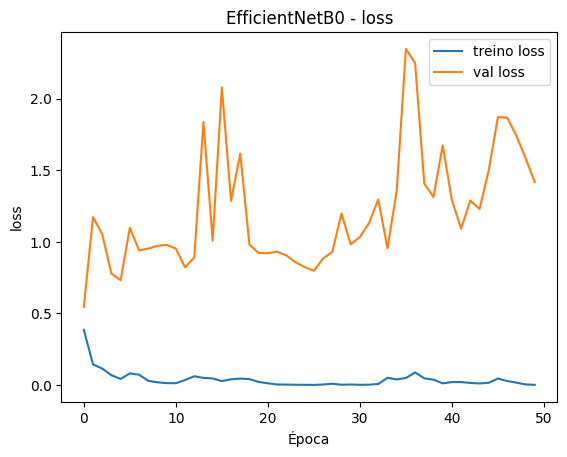

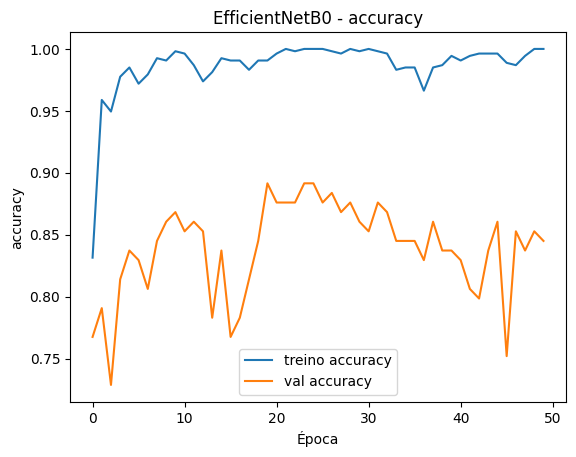

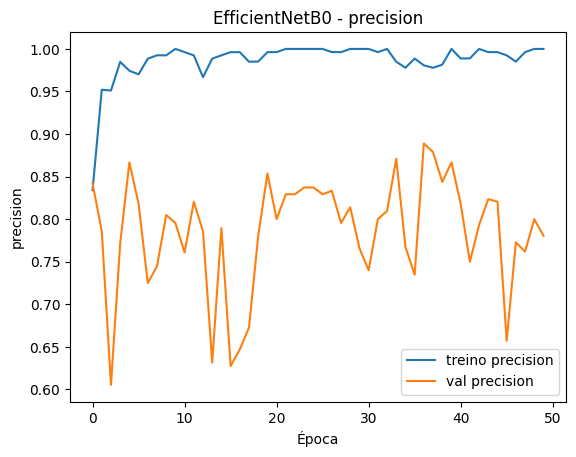

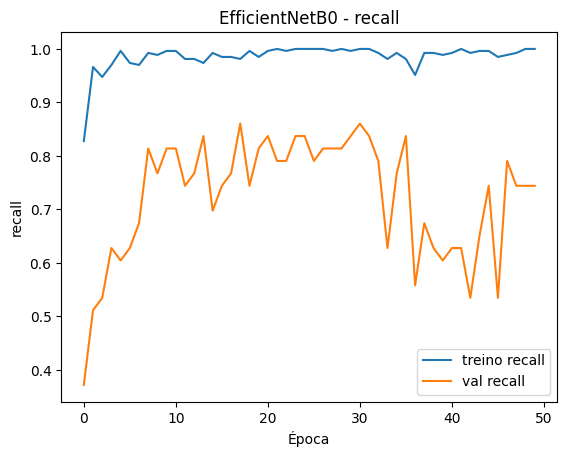

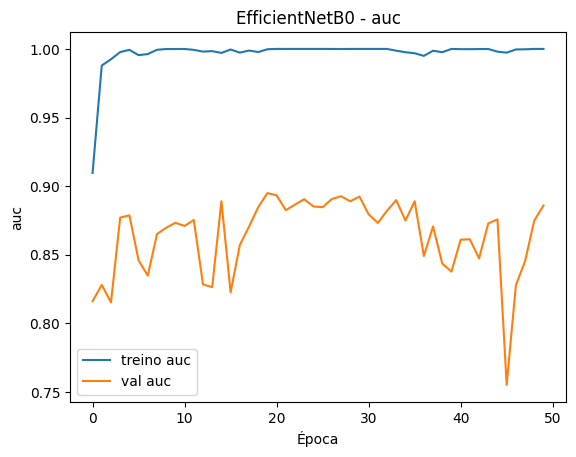

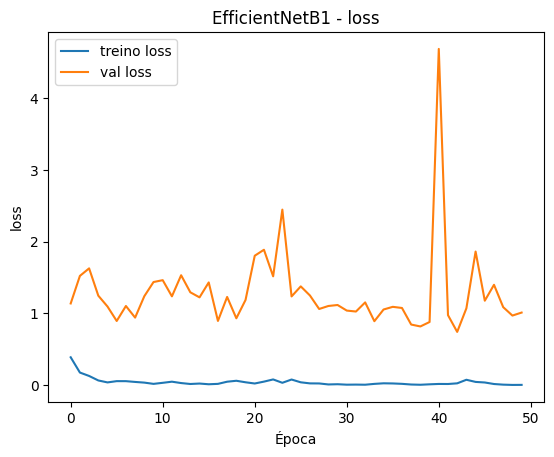

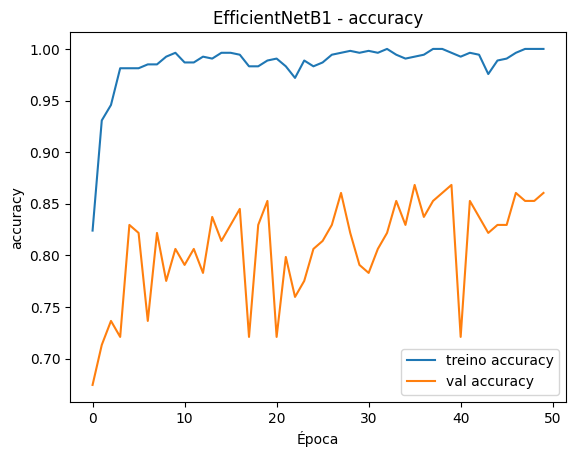

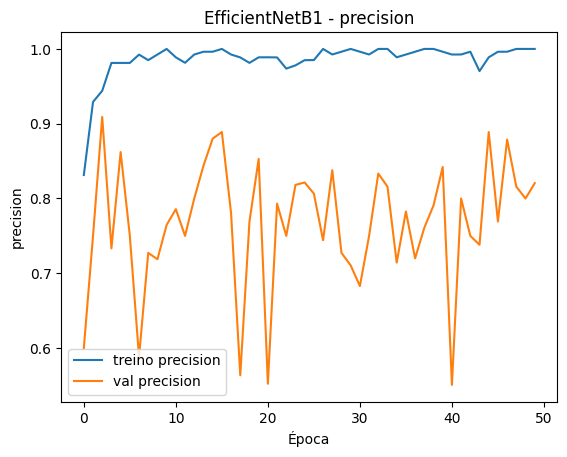

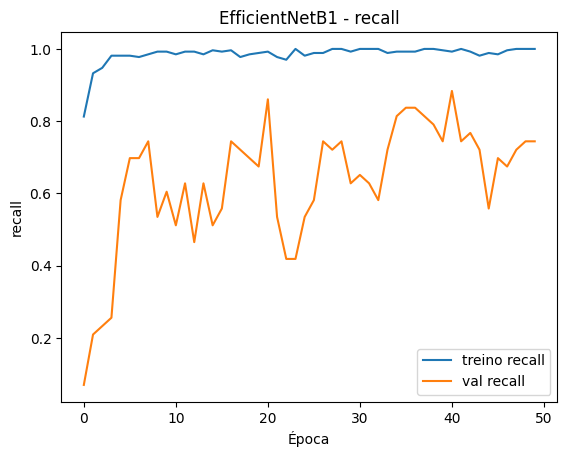

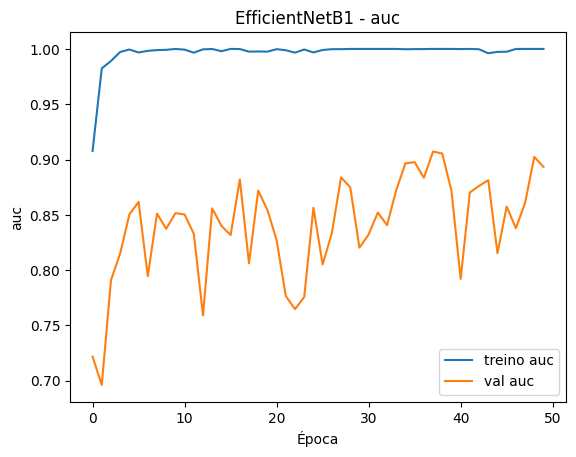

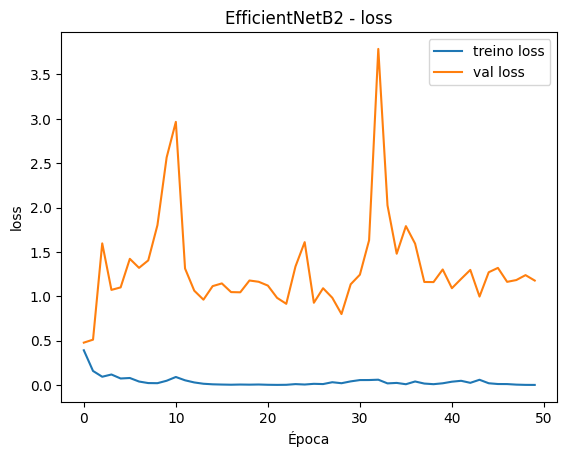

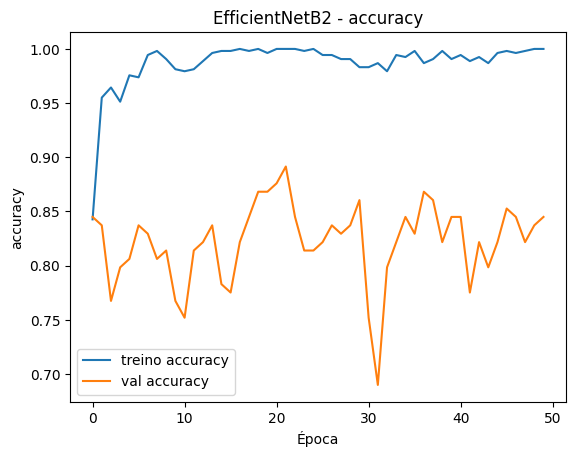

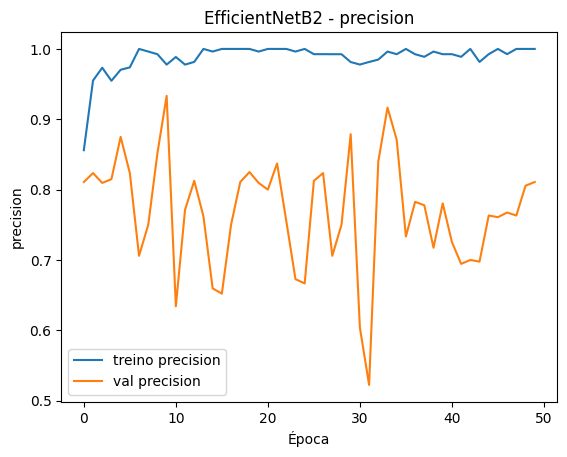

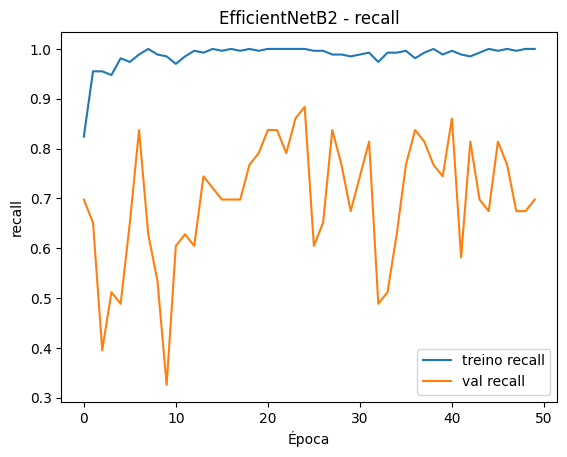

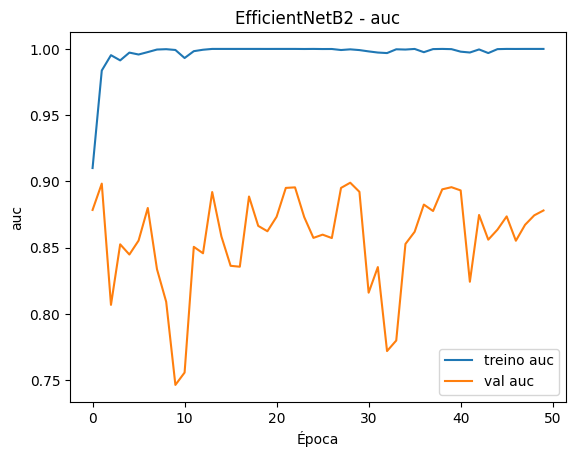

In [ ]:
def plot_hist(hist, title_prefix):
    for m in ["loss", "accuracy", "precision", "recall", "auc"]:
        if f"val_{m}" in hist:
            plt.figure()
            plt.plot(hist[m], label=f"treino {m}")
            plt.plot(hist[f"val_{m}"], label=f"val {m}")
            plt.xlabel("Época"); plt.ylabel(m); plt.legend(); plt.title(f"{title_prefix} - {m}")
            plt.show()

for name, hist in histories.items():
    plot_hist(hist, f"EfficientNet{name}")

## 13)


Resultados — TESTE (ROI+PP+AD + ENB0)
Acurácia:        76.15%
Especificidade:  95.35%
Sensibilidade:   38.64%
Precisão:        80.95%
F1-score:        52.31%
AUC-ROC:         0.90803

Resultados — TESTE (ROI+PP+AD + ENB1)
Acurácia:        87.69%
Especificidade:  89.53%
Sensibilidade:   84.09%
Precisão:        80.43%
F1-score:        82.22%
AUC-ROC:         0.92838



Resultados — TESTE (ROI+PP+AD + ENB2)
Acurácia:        89.23%
Especificidade:  97.67%
Sensibilidade:   72.73%
Precisão:        94.12%
F1-score:        82.05%
AUC-ROC:         0.94371

Resultados — TESTE (ROI+PP+AD + Ensemble B0/B1/B2)
Acurácia:        90.00%
Especificidade:  96.51%
Sensibilidade:   77.27%
Precisão:        91.89%
F1-score:        83.95%
AUC-ROC:         0.95190


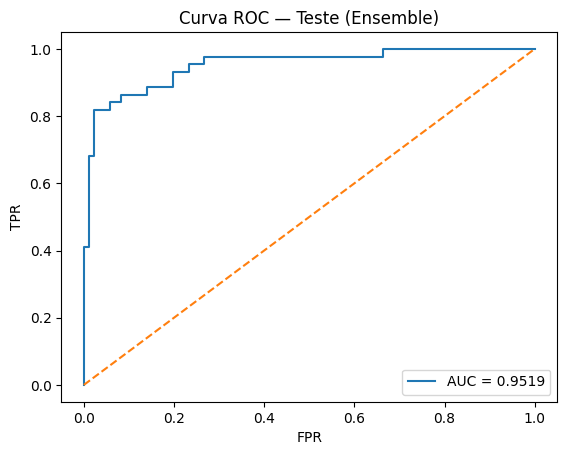

In [ ]:
def evaluate_model(model, test_ds, name=""):
    y_prob = model.predict(test_ds, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    y_true = np.concatenate([y.numpy() for _, y in test_ds.unbatch().batch(1024)], axis=0)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    print(f"\nResultados — TESTE ({name})")
    print(f"Acurácia:       {acc*100:6.2f}%")
    print(f"Especificidade: {specificity*100:6.2f}%")
    print(f"Sensibilidade:  {rec*100:6.2f}%")
    print(f"Precisão:       {prec*100:6.2f}%")
    print(f"F1-score:       {f1*100:6.2f}%")
    print(f"AUC-ROC:        {auc:8.5f}")
    return y_true, y_prob, y_pred

# Carrega os melhores pesos (garantia)
model_b0.load_weights(ckpts["B0"])
model_b1.load_weights(ckpts["B1"])
model_b2.load_weights(ckpts["B2"])

# Avaliação individual
y_true_b0, y_prob_b0, y_pred_b0 = evaluate_model(model_b0, test_ds_b0, name="ROI+PP+AD + ENB0")
y_true_b1, y_prob_b1, y_pred_b1 = evaluate_model(model_b1, test_ds_b1, name="ROI+PP+AD + ENB1")
y_true_b2, y_prob_b2, y_pred_b2 = evaluate_model(model_b2, test_ds_b2, name="ROI+PP+AD + ENB2")

# Sanity: rótulos verdadeiros devem coincidir
assert np.array_equal(y_true_b0, y_true_b1) and np.array_equal(y_true_b0, y_true_b2), "Mis-match nos rótulos do teste"
y_true = y_true_b0

# Ensemble por votação (maioria)
votes = np.stack([y_pred_b0, y_pred_b1, y_pred_b2], axis=1)
y_pred_ens = (np.sum(votes, axis=1) >= 2).astype(int)

# Para AUC do ensemble, podemos usar a média das probabilidades
y_prob_ens = (y_prob_b0 + y_prob_b1 + y_prob_b2) / 3.0

acc  = accuracy_score(y_true, y_pred_ens)
prec = precision_score(y_true, y_pred_ens, zero_division=0)
rec  = recall_score(y_true, y_pred_ens)
f1   = f1_score(y_true, y_pred_ens)
auc  = roc_auc_score(y_true, y_prob_ens)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_ens).ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

print("\nResultados — TESTE (ROI+PP+AD + Ensemble B0/B1/B2)")
print(f"Acurácia:       {acc*100:6.2f}%")
print(f"Especificidade: {specificity*100:6.2f}%")
print(f"Sensibilidade:  {rec*100:6.2f}%")
print(f"Precisão:       {prec*100:6.2f}%")
print(f"F1-score:       {f1*100:6.2f}%")
print(f"AUC-ROC:        {auc:8.5f}")

# Curva ROC do Ensemble
fpr, tpr, thr = roc_curve(y_true, y_prob_ens)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:0.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Curva ROC — Teste (Ensemble)")
plt.legend(); plt.show()